In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import os 

from PIL import Image
from scipy import ndimage as nd
from tkinter import Tcl

from poreUtils import *

In [2]:
# write a function to load volume from the path

def load_volume(volume_path, clip_low=0.0005, clip_high=0.003):
    """Load the volume from the path provided.

    Args:
    volume_path (str): Path to the volume.
    clip_low (float, optional): Minimum value to clip the data. Defaults to 0.0005.
    clip_high (float, optional): Maximum value to clip the data. Defaults to 0.003.

    Returns:
    vol (numpy array): The volume loaded from the path.

    Raises:
    Exception: If the path does not exist, raises an exception.
    """
    try:
        tiffs = os.listdir(volume_path)

        slices = Tcl().call('lsort', '-dict', tiffs)
        shape = Image.open(os.path.join(volume_path, slices[0])).size
        vol = np.empty(shape=(len(slices), shape[0], shape[1]), dtype=np.uint8)

        for i, fname in enumerate(slices):
            im = Image.open(os.path.join(volume_path, fname))
            imarray = np.array(im)
            imarray = np.clip(imarray, clip_low, clip_high)
            imarray = norm8bit(imarray)
            vol[i, :, :] = imarray

        return vol

    except:
        raise Exception(f"{volume_path} : path does not exists")

In [3]:
def interactive_visualize(arr, cmap='gray', **kwargs):
    """
    This function creates an interactive visualization of the input array in 2D or 3D.

    Parameters:
    arr (ndarray): The input array to be visualized.
    cmap (str): The colormap to use for the plot. Default is 'viridis'
    **kwargs: Additional keyword arguments to be passed to plt.imshow.

    Returns:
    None
    """
    
    if arr.ndim == 2:
        plt.imshow(arr, cmap=cmap, **kwargs)
        plt.show()
    elif arr.ndim == 3:
    
        slider = widgets.IntSlider(
            min=0, max=arr.shape[0], step=1, value=np.rint(arr.shape[0] / 2))

        def visualize_morph(slice_number):
            """
            This function plots the 3D visualization of the input array.

            Parameters:
            slice_number (int): The slice number of the input array to be visualized.

            Returns:
            None
            """
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
            plt.subplots_adjust(hspace=0.1, wspace=0.1)

            ax1.imshow(arr[slice_number, :, :], cmap=cmap, **kwargs)
            ax2.imshow(arr[:, slice_number, :], cmap=cmap, **kwargs)
            ax2.set_xticks([])
            ax2.set_yticks([])
            ax3.imshow(arr[:, :, slice_number], cmap=cmap, **kwargs)
            ax3.set_xticks([])
            ax3.set_yticks([])
            plt.show()


        widgets.interact(visualize_morph, slice_number=slider)
    
    else:
        raise ValueError("Input array must be either 2D or 3D.")

In [4]:
def apply_morphology(arr, filter_type, filter_size=None, iterations=1):
    """
    Perform morphological operations on binary input arrays.

    Parameters
    ----------
    arr : numpy.ndarray
        Binary input array to apply morphological operations on.
    filter_type : str
        Type of morphological operation to apply. Available options are:
        - 'erosion'
        - 'dilation'
        - 'opening'
        - 'closing'
        - 'fill_holes'
    filter_size : list of ints, optional
        Size of the morphological filter. Defaults to None.
    iterations : int, optional
        Number of iterations to perform the morphological operation. Defaults to 1.

    Returns
    -------
    filtered_arr : numpy.ndarray
        Binary array after applying the morphological operation.

    Raises
    ------
    ValueError
        If the input array is not of binary data type.
        If the filter size is not None and does not have the same number of dimensions as the input array.
        If the filter size is not None and is greater than or equal to the size of the input array in each dimension.
        If the filter type is not a valid option.
    """
    
    if not np.issubdtype(arr.dtype, np.bool_):
        raise ValueError("Input array is not of binary data type.")
    
    if filter_size is not None and len(filter_size) != arr.ndim:
        raise ValueError("Filter size must have the same number of dimensions as the input array.")
    
    if filter_size is not None:
        for i in range(arr.ndim):
            if filter_size[i] >= arr.shape[i]:
                raise ValueError("Filter size must be smaller than the size of the input array in each dimension.")        
        size = np.ones(shape=filter_size)
    
    if filter_type == "erosion":
        filtered_arr = nd.binary_erosion(arr, structure=size, iterations=iterations)
    elif filter_type == "dilation":
        filtered_arr = nd.binary_dilation(arr, structure=size, iterations=iterations)
    elif filter_type == "opening":
        filtered_arr = nd.binary_opening(arr, structure=size, iterations=iterations)
    elif filter_type == "closing":
        filtered_arr = nd.binary_closing(arr, structure=size, iterations=iterations)
    elif filter_type == "fill_holes":
        filtered_arr = nd.binary_fill_holes(arr, structure=size)
    else:
        raise ValueError("Invalid filter type. Available options are 'erosion', 'dilation', 'opening', 'closing', and 'fill_holes'.")
    
    return filtered_arr


In [5]:
def apply_morphology_inorder(arr, morphology_operations=None):
    """
    Applies morphology operations to the input array in a specified order.

    Args:
    - arr (numpy.ndarray): Input array to which morphology operations will be applied.
    - morphology_operations (list): List of tuples, where each tuple represents a morphology operation
    to be applied to the input array. Each tuple should have 2 or 3 elements:
      - First element is a string representing the name of the morphology operation.
      - Second element is an integer representing the size of the structuring element or filter.
      - Third element (optional) is an integer representing the number of iterations for the morphology
      operation. This element is only required for erosion, dilation, opening, and closing operations.

    Returns:
    - morph_arr (numpy.ndarray): Output array after applying all specified morphology operations
    in the specified order.

    If morphology_operations is None, the function prints a message and returns None.

    """
    if morphology_operations:
        morph_arr = arr
        for operation in morphology_operations:
            if operation[0] == 'fill_holes':
                morph_arr = apply_morphology(morph_arr, filter_type=operation[0], filter_size=operation[1])
            else:
                # Apply other morphological operations
                morph_arr = apply_morphology(morph_arr, filter_type=operation[0], filter_size=operation[1], iterations=operation[2])

        return morph_arr
    else: 
        print('No morphology operations are specified.')

            
    

In [6]:
def visualize_morphology(arr, th_arr=None, morphology_operations=None, final_comparison=False, **kwargs):
    """
    Visualize thresholding and morphological operations on an input array.
    
    Args:
        arr (ndarray): Input array to be visualized.
        threshold (float, optional): Threshold value for the input array. Defaults to None.
        morphology_operations (list, optional): List of morphology operations to be applied on the input array.
            Each operation is a list containing the operation type (str), kernel size (lidt of int), and iteration number (int).
            Defaults to None.
        reverse (bool, optional): Flag to reverse the thresholding operation. Defaults to False.
    """

    # Show the original array
    interactive_visualize(arr, **kwargs)
    
    if th_arr is not None:
        interactive_visualize(th_arr, **kwargs)
    else:
        print('No threshold image is specified.')
    
    
    if morphology_operations:
        morph_arr = th_arr
        for operation in morphology_operations:
            if operation[0] == 'fill_holes':
                morph_arr = apply_morphology(morph_arr, filter_type=operation[0], filter_size=operation[1])
                print(operation[0])
                interactive_visualize(morph_arr, **kwargs)
            else:
                # Apply other morphological operations
                for i in range(operation[2]):
                    morph_arr = apply_morphology(morph_arr, filter_type=operation[0], filter_size=operation[1])
                    print(f"{operation[0]} kernel size {operation[1]} iteration: {i + 1}")
                    interactive_visualize(morph_arr, **kwargs)
    else: 
        print('No morphology operations are specified.')
    
    if final_comparison and morphology_operations is not None:
        print('comparison between first and final volume.')
        interactive_visualize(th_arr, **kwargs)
        interactive_visualize(morph_arr, **kwargs)

In [28]:
# scan_path = 'D:\\mpi_pc\\sagar\\Data\\MD_1264_A10_Z6.6mm\\roi\\200-500x1050-1350x1000-1300'
scan_path = 'D:\\mpi_pc\\sagar\\Data\\MD_1264_A1_1_Z3.3mm\\roi\\0-300x600-900x1400-1700'
# scan_path = 'D:\\mpi_pc\\sagar\\Data\\MD_1264_A2_1_Z3.3mm\\roi\\1000-1300x1000-1300x2000-2300'


In [29]:
vol = load_volume(scan_path)

In [30]:
th_vol = vol < 55 

In [31]:
morphology_operations = [ ['closing', (3,3,3), 1], ['dilation', (3,3,3), 1] , ['erosion', (3,3,3), 1] ]

In [32]:
visualize_morphology(vol, th_vol, morphology_operations, final_comparison=True)

interactive(children=(IntSlider(value=150, description='slice_number', max=300), Output()), _dom_classes=('wid…

interactive(children=(IntSlider(value=150, description='slice_number', max=300), Output()), _dom_classes=('wid…

closing kernel size (3, 3, 3) iteration: 1


interactive(children=(IntSlider(value=150, description='slice_number', max=300), Output()), _dom_classes=('wid…

dilation kernel size (3, 3, 3) iteration: 1


interactive(children=(IntSlider(value=150, description='slice_number', max=300), Output()), _dom_classes=('wid…

erosion kernel size (3, 3, 3) iteration: 1


interactive(children=(IntSlider(value=150, description='slice_number', max=300), Output()), _dom_classes=('wid…

comparison between first and final volume.


interactive(children=(IntSlider(value=150, description='slice_number', max=300), Output()), _dom_classes=('wid…

interactive(children=(IntSlider(value=150, description='slice_number', max=300), Output()), _dom_classes=('wid…

In [12]:
morph_vol = apply_morphology_inorder(th_vol, morphology_operations)

In [13]:
%matplotlib inline
interactive_visualize(morph_vol)

interactive(children=(IntSlider(value=150, description='slice_number', max=300), Output()), _dom_classes=('wid…

In [14]:
dt3d = nd.distance_transform_edt(morph_vol)

In [15]:
th_dt3d = dt3d > 8

In [19]:
%matplotlib notebook
interactive_visualize(dt3d, cmap='jet')
interactive_visualize(th_dt3d, cmap='jet')
interactive_visualize(th_dt3d* dt3d, cmap='jet')

interactive(children=(IntSlider(value=150, description='slice_number', max=300), Output()), _dom_classes=('wid…

interactive(children=(IntSlider(value=150, description='slice_number', max=300), Output()), _dom_classes=('wid…

interactive(children=(IntSlider(value=150, description='slice_number', max=300), Output()), _dom_classes=('wid…

In [17]:
fib_vol = th_dt3d* dt3d

In [18]:
from skimage.measure import label

In [29]:
mask = fib_vol > 10
markers = label(mask)
interactive_visualize(markers, cmap='jet')

interactive(children=(IntSlider(value=150, description='slice_number', max=300), Output()), _dom_classes=('wid…

In [31]:
from skimage.segmentation import watershed
# Using porespy 
import porespy as ps
ps.visualization.set_mpl_style()
np.random.seed(1)

In [32]:
labels = watershed(-fib_vol, markers, mask=fib_vol)
interactive_visualize(labels, cmap='jet')
props = ps.metrics.regionprops_3D(labels)

interactive(children=(IntSlider(value=150, description='slice_number', max=300), Output()), _dom_classes=('wid…

In [61]:
img = fib_vol[151, :, :]

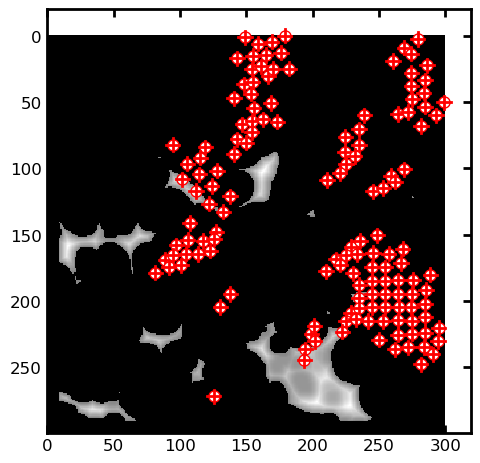

In [76]:
%matplotlib inline
show_com(img, 10)

In [89]:


def sliding_window_max(img, window_size, step_size):
    max_pixels = []
    height, width = img.shape
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')
    for y in range(0, height - window_size + 1, step_size):
        for x in range(0, width - window_size + 1, step_size):
            window = img[y:y+window_size, x:x+window_size]
            max_pixel = np.max(window)
            if max_pixel > 0:
                max_pixel_pos = np.unravel_index(np.argmax(window), window.shape)
                max_pixel_pos = (max_pixel_pos[1]+x, max_pixel_pos[0]+y)
                max_pixels.append((max_pixel, max_pixel_pos))
                rect = plt.Rectangle((x, y), window_size, window_size, fill=False, edgecolor='r', lw=1)
                ax.add_patch(rect)
                ax.plot(max_pixel_pos[0], max_pixel_pos[1], 'ro', markersize=2)
    plt.show()
    return max_pixels




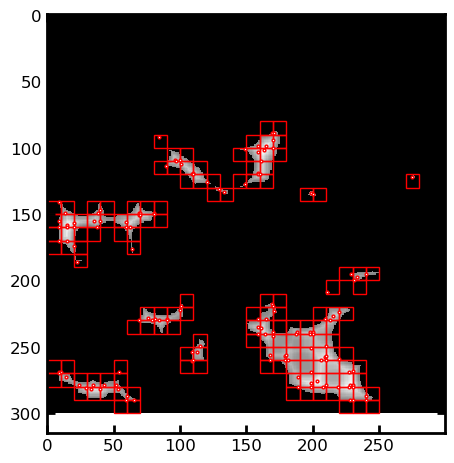

In [91]:
max_pixels = sliding_window_max(img, 10, 10)

In [97]:
def sliding_window_max(img, window_size, step_size):
    max_pixels = []
    height, width = img.shape
    output_img = np.dstack((img, img, img))
    fig, ax = plt.subplots()
    ax.imshow(output_img, cmap='gray')
    for y in range(0, height - window_size + 1, step_size):
        for x in range(0, width - window_size + 1, step_size):
            if x + window_size > width or y + window_size > height:
                continue
            window = img[y:y+window_size, x:x+window_size]
            max_pixel = np.max(window)
            if max_pixel > 0:
                max_pixel_pos = np.unravel_index(np.argmax(window), window.shape)
                max_pixel_pos = (max_pixel_pos[1]+x, max_pixel_pos[0]+y)
                max_pixels.append((max_pixel, max_pixel_pos))
                rect = plt.Rectangle((x, y), window_size, window_size, fill=False, edgecolor='r', linewidth=1)
                ax.add_patch(rect)
                ax.text(max_pixel_pos[0], max_pixel_pos[1], str(max_pixel), color='g', fontsize=5)
    plt.show()
    return max_pixels, output_img


[10:16:42] WARNING  Clipping input data to the valid range for imshow with RGB data ([0..1] for floats ]8;id=682556;file://C:\Users\Manager\.conda\envs\porespy\lib\site-packages\matplotlib\image.py\image.py]8;;\:]8;id=356417;file://C:\Users\Manager\.conda\envs\porespy\lib\site-packages\matplotlib\image.py#720\720]8;;\
                    or [0..255] for integers).                                                                     

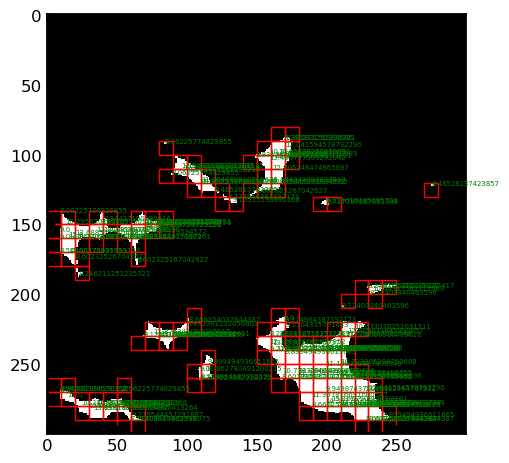

In [99]:
max_pixels, _ = sliding_window_max(img, 10, 10)

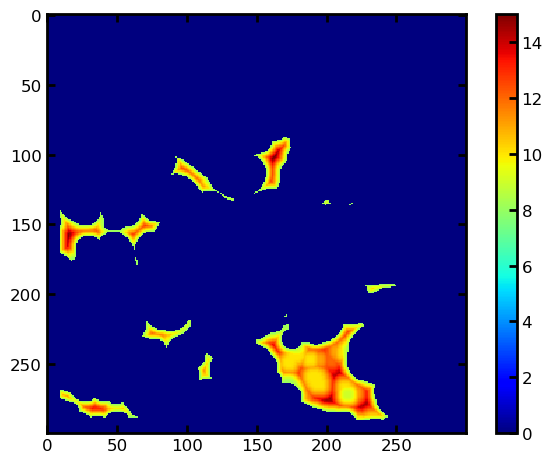

In [106]:
plt.imshow(fib_vol[150], cmap='jet')
plt.colorbar()
plt.tight_layout()
plt.show()

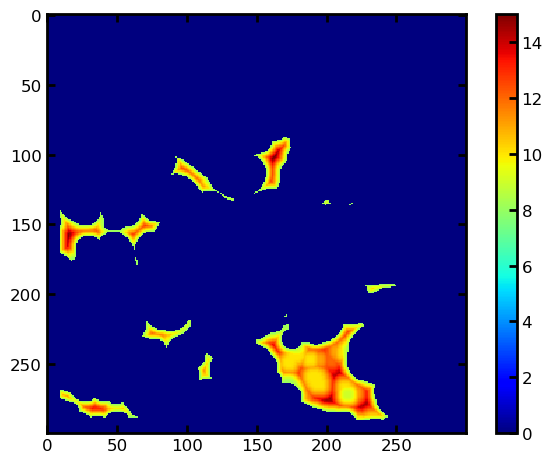

In [100]:
plt.imshow(fib_vol[150], cmap='jet')
plt.colorbar()
plt.tight_layout()
plt.show()


In [94]:

def sliding_window_max3d(volume, window_size, step_size):
    max_pixels = []
    depth, height, width = volume.shape
    fig, ax = plt.subplots()
    ax.imshow(volume[0], cmap='gray')
    for z in range(0, depth - window_size[0] + 1, step_size[0]):
        for y in range(0, height - window_size[1] + 1, step_size[1]):
            for x in range(0, width - window_size[2] + 1, step_size[2]):
                window = volume[z:z+window_size[0], y:y+window_size[1], x:x+window_size[2]]
                max_pixel = np.max(window)
                if max_pixel > 0:
                    max_pixel_pos = np.unravel_index(np.argmax(window), window.shape)
                    max_pixel_pos = (max_pixel_pos[2]+x, max_pixel_pos[1]+y, max_pixel_pos[0]+z)
                    max_pixels.append((max_pixel, max_pixel_pos))
                    rect = plt.Rectangle((x, z), window_size[2], window_size[0], fill=False, edgecolor='r', lw=1)
                    ax.add_patch(rect)
                    ax.plot(max_pixel_pos[0], max_pixel_pos[2], 'ro', markersize=2)
    plt.show()
    return max_pixels


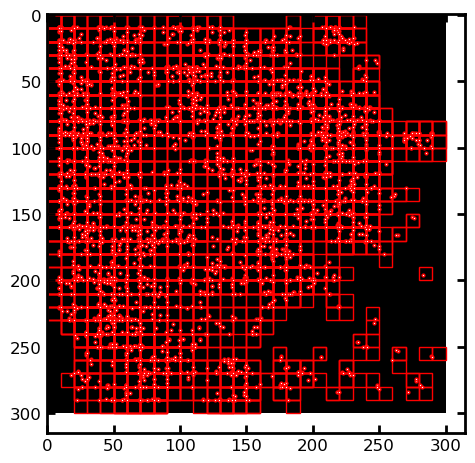

In [95]:
max_pixels3d = sliding_window_max3d(fib_vol, (10, 10, 10), (10, 10, 10))

In [96]:
max_pixels3d

[(8.06225774829855, (19, 34, 9)),
 (8.54400374531753, (20, 35, 9)),
 (9.0, (114, 55, 9)),
 (9.0, (113, 60, 9)),
 (9.0, (98, 75, 9)),
 (8.54400374531753, (99, 80, 9)),
 (8.306623862918075, (100, 82, 9)),
 (8.54400374531753, (69, 97, 9)),
 (9.0, (70, 95, 9)),
 (9.0, (209, 98, 9)),
 (9.0, (210, 97, 9)),
 (9.0, (71, 100, 9)),
 (8.306623862918075, (80, 101, 9)),
 (8.48528137423857, (95, 109, 9)),
 (9.0, (207, 100, 9)),
 (9.0, (210, 100, 9)),
 (8.48528137423857, (95, 110, 9)),
 (8.94427190999916, (9, 145, 9)),
 (8.54400374531753, (10, 145, 9)),
 (8.366600265340756, (39, 149, 9)),
 (9.0, (41, 149, 9)),
 (8.717797887081348, (39, 150, 9)),
 (9.0, (40, 150, 9)),
 (9.0, (217, 154, 9)),
 (8.06225774829855, (49, 161, 9)),
 (9.0, (48, 187, 9)),
 (8.306623862918075, (50, 183, 9)),
 (9.0, (124, 188, 9)),
 (8.06225774829855, (130, 189, 9)),
 (8.06225774829855, (209, 185, 9)),
 (9.0, (214, 182, 9)),
 (8.246211251235321, (9, 198, 9)),
 (8.602325267042627, (19, 196, 9)),
 (8.602325267042627, (22, 195, 9))